# Assignment 2
## Problem 2 - Keyword Recognition

In this notebook you can train a CNN model for keyword recognition. Parts of the notebook are inspired by [this nice
tutorial](https://pytorch.org/tutorials/intermediate/speech_command_recognition_with_torchaudio.html).

In [1]:
%reload_ext autoreload
%autoreload 2
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
from matplotlib import cm
from tqdm.notebook import tqdm

from src.models.keyword_cnn_felix import KeyWordCNN1d,  KeyWordCNN2d
from src.utils.plotting import init_plot_style
init_plot_style()

First we load the data. Make sure you have downloaded and extracted the dataset in
`project-root/data/audio/`.

In [2]:
from src.data.speech_commands_data import SpeechCommandsData

scdata = SpeechCommandsData()

# create training, validation and test sets
train_set = scdata.get_subset('training')
print(f'We have {len(train_set)} samples in the training set.')
validation_set = scdata.get_subset('validation')
print(f'We have {len(validation_set)} samples in the validation set.')
test_set = scdata.get_subset('testing')
print(f'We have {len(test_set)} samples in the testing set.')


We have 15530 samples in the training set.
We have 1898 samples in the validation set.
We have 2037 samples in the testing set.


Let us inspect the dataset. A data point is a tuple made of a waveform
(the audio signal), the sample rate, the utterance (label), the ID of
the speaker, the number of the utterance. We can also plot and listen to an example recording.

The shape of the waveform is torch.Size([1, 12056]).
The sample rate of the waveform is 16000.


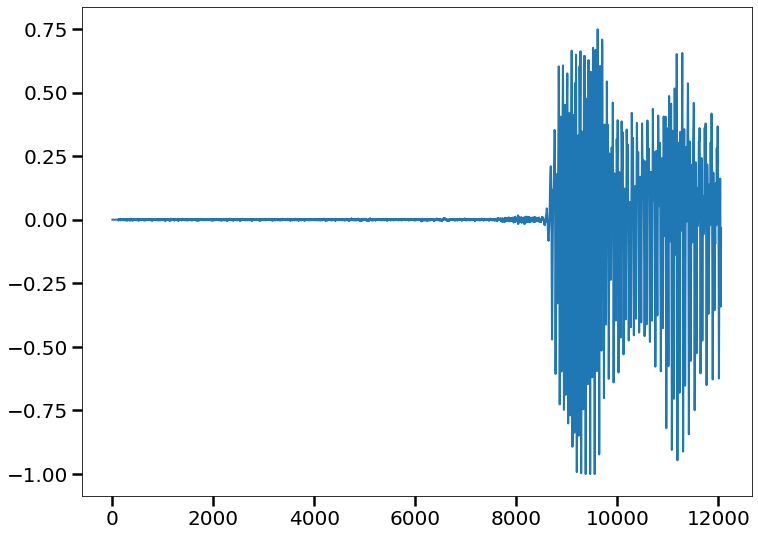

In [3]:
waveform, sample_rate, label, speaker_id, utterance_number = train_set[1000]

print(f'The shape of the waveform is {waveform.shape}.')
print(f'The sample rate of the waveform is {sample_rate}.')

plt.figure()
plt.plot(waveform.T.numpy())
ipd.Audio(waveform.numpy(), rate=sample_rate)


In our setup we do not feed the raw waveform directly in to the CNN but we apply
a preprocessing step beforehand. Specifically, we compute a (variable length) sequence of
40 log Mel Frequency Cepstral Coefficients (MFCCs) for each waveform. Below we define the
transform, apply it on an example waveform an plot the resulting lMFCC spectrum.

/home/felix/anaconda3/envs/nsp2021/lib/python3.7/site-packages/torchaudio/functional/functional.py:358: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


The shape of the MFCC feature sequence is torch.Size([1, 40, 61])


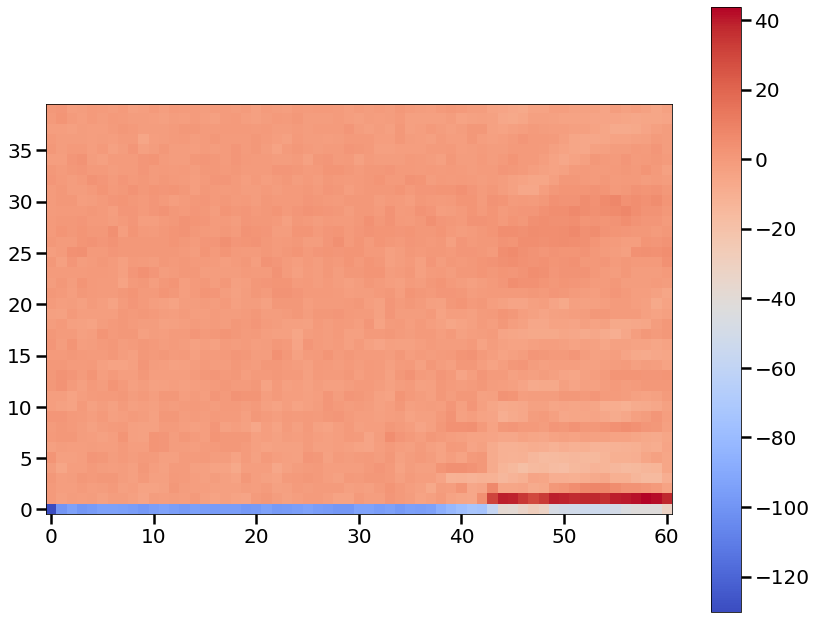

In [4]:
mfcc_transform = torchaudio.transforms.MFCC(sample_rate, log_mels=True)
mfcc_sequence = mfcc_transform(waveform)
print(f'The shape of the MFCC feature sequence is {mfcc_sequence.shape}')

fig, ax = plt.subplots()
cax = ax.imshow(mfcc_sequence.squeeze(), cmap=cm.coolwarm, origin='lower')
plt.colorbar(cax)
plt.tight_layout()


We also have to extract the labels (the keywords) from the dataset. For the implementation
we assign each keyword a unique index (number) representing the target class.

In [25]:
# define mappings from labels to indices and vice versa
labels = scdata.labels
label_to_index = lambda label: torch.tensor(labels.index(label))
index_to_label = lambda index: labels[index]

print(f'There are {len(labels)} different utterances in the dataset, i.e. ' + repr(labels))
print('Mapping from label to index: ' + str(label_to_index('go')))
print('Mapping from index to label: ' + index_to_label(1))


There are 5 different utterances in the dataset, i.e. ['four', 'go', 'no', 'stop', 'yes']
Mapping from label to index: tensor(1)
Mapping from index to label: go


Below we define our model and see how many parameters it has.

In [111]:

model = KeyWordCNN1d(num_classes=5,num_features=40,num_kernels=80, mem_depth=80, num_groups = 1)
#model = KeyWordCNN2d(num_classes=5,num_features=40,num_kernels=5, mem_depth=15)


count_parameters = lambda model: sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model)} trainable parameters.')


The model has 278101 trainable parameters.


Here we define our training and test epoch functions. You could also include
a validation epoch (instead of the test epoch) here.

In [112]:

def train_epoch(model, optimizer, epoch, log_interval):
    model.train() # puts the model into train model

    loss_list = []
    for batch_idx, (data, target) in enumerate(train_loader):

        # apply the mfcc transform on the data and compute model output
        data = mfcc_transform(data)
        #print("data shape: ", data.shape)
        output = model(data)
        #print("output shape: ", data.shape)

        # compute the negative log-likelihood and update parameters
        loss = F.nll_loss(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f'Training epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} samples'
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.4f}')

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        loss_list.append(loss.item())

    return loss_list

def test_epoch(model, epoch):
    model.eval() # puts the model into eval mode

    correct = 0
    for data, target in test_loader:

        # apply the mfcc transform on the data and compute model output
        data = mfcc_transform(data)
        output = model(data)

        # count correct predictions
        predicted_targets = output.argmax(-1)
        correct += predicted_targets.eq(target).sum().item()

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")


Finally, we can train and evaluate our model.

  0%|          | 0/4 [00:00<?, ?it/s]

Training epoch: 1 [0/15530 samples(0%)]	Loss: 1.7305
Training epoch: 1 [2500/15530 samples(16%)]	Loss: 0.7948
Training epoch: 1 [5000/15530 samples(32%)]	Loss: 0.7095
Training epoch: 1 [7500/15530 samples(48%)]	Loss: 0.5658
Training epoch: 1 [10000/15530 samples(64%)]	Loss: 0.4603
Training epoch: 1 [12500/15530 samples(80%)]	Loss: 0.2289
Training epoch: 1 [15000/15530 samples(96%)]	Loss: 0.4560

Test Epoch: 1	Accuracy: 1798/2037 (88%)

Training epoch: 2 [0/15530 samples(0%)]	Loss: 0.1598
Training epoch: 2 [2500/15530 samples(16%)]	Loss: 0.2596
Training epoch: 2 [5000/15530 samples(32%)]	Loss: 0.7704
Training epoch: 2 [7500/15530 samples(48%)]	Loss: 0.4157
Training epoch: 2 [10000/15530 samples(64%)]	Loss: 0.1418
Training epoch: 2 [12500/15530 samples(80%)]	Loss: 0.0997
Training epoch: 2 [15000/15530 samples(96%)]	Loss: 0.1408

Test Epoch: 2	Accuracy: 1878/2037 (92%)

Training epoch: 3 [0/15530 samples(0%)]	Loss: 0.0728
Training epoch: 3 [2500/15530 samples(16%)]	Loss: 0.0696
Training e

Text(0, 0.5, 'Negative Log-Likelihood')

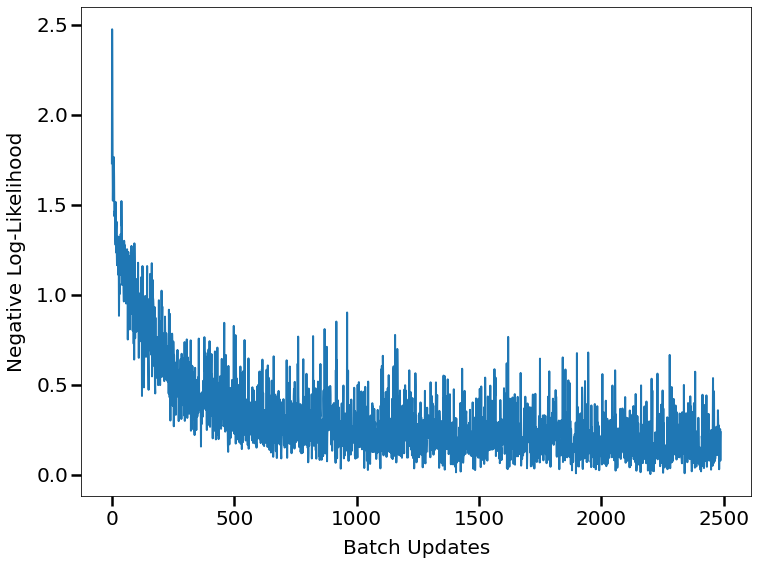

In [113]:
# 1d-CNN: max 93% after 4 epocs, [num_kernels=20, mem_depth=12, batch_size = 25, lr=0.001, weight_decay=0.0001]
# 1d-CNN with groups: max 87% after 4 epocs, [num_kernels=20, mem_depth=12, batch_size = 25, lr=0.001, weight_decay=0.0001]
# 2D-CNN: max 85% after 2 epocs, [num_kernels=5, mem_depth=15, batch_size = 25, lr=0.001, weight_decay=0.0001]
#training setup
log_interval = 100 # log training stats after so many batches
num_epochs = 4 # number of epochs (cycles through the whole training set)

# create data loaders for the subsets
batch_size = 25
train_loader = scdata.get_dataloader(train_set, batch_size, shuffle=True)
validation_loader = scdata.get_dataloader(validation_set, batch_size)
test_loader = scdata.get_dataloader(test_set, batch_size)

# define and parameterize the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

loss_list = []

# set up the progress bar
pbar_update = 1 / (len(train_loader) + len(test_loader))
with tqdm(total=num_epochs) as pbar:
    for epoch in range(1, num_epochs + 1):
        loss_list += train_epoch(model, optimizer, epoch, log_interval)
        test_epoch(model, epoch)
        scheduler.step()

# Let's plot the training loss versus the number of iteration.
plt.figure()
plt.plot(loss_list)
plt.xlabel('Batch Updates')
plt.ylabel('Negative Log-Likelihood')


Let's pick out some example of the test set and see what our model predicts!

In [114]:
def predict_word(waveform):
    """Predict the label for the input waveform.

    Parameters
    ----------
    waveform : torch.Tensor
        The input waveform.

    Returns
    ----------
    str
        The predicted label.
    """
    sequence = mfcc_transform(waveform)
    pred = model(sequence).argmax(-1)
    return index_to_label(pred.squeeze())


waveform, sample_rate, utterance, *_ = test_set[1]
print(f"Expected: {utterance}. Predicted: {predict_word(waveform)}.")
ipd.Audio(waveform.numpy(), rate=sample_rate)


Expected: go. Predicted: no.


It may be insightful to have a look at the confusion matrix of your model's predictions.

In [115]:
confusion_matrix = np.zeros((len(labels), len(labels)))
for i, (waveform, _, utterance, *_) in enumerate(test_set):
    output = predict_word(waveform)
    confusion_matrix[label_to_index(output), label_to_index(utterance)] += 1

print(confusion_matrix)

fig, ax = plt.subplots(figsize=(10, 8))
plt.imshow(confusion_matrix)
plt.xlabel('Prediction')
plt.ylabel('Label')

# Labels and Ticks
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Annotation
for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, confusion_matrix[i, j].astype(int),
                       ha="center", va="center", color="w")

plt.show()

KeyboardInterrupt: 